In [1]:
import gc
gc.collect()

144

In [2]:
from matplotlib import pyplot as plt
# from matplotlib import style
import pandas as pd
import numpy as np
import swifter
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import itertools
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler
from sklearn.model_selection import train_test_split
import re
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import nltk
# import spacy 
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras as k
import tensorflow as tf
# import torch
from scipy import stats
import seaborn as sns
from numpy.random import seed
import tensorflow_hub as hub

from gensim.models import KeyedVectors
from transformers import AutoModel, BertTokenizerFast,BertTokenizer, BertModel

lemmatizer = WordNetLemmatizer()
scaler = MinMaxScaler(feature_range=(0, 1))



2022-05-19 14:00:48.516081: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-19 14:00:48.516115: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
nltk.download('stopwords')
stop_words = stopwords.words('english') 
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/users/s/sarthak_7034/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/users/s/sarthak_7034/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/users/s/sarthak_7034/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
#Read dataset
data = pd.read_csv("./all_data.csv").drop("Unnamed: 0", axis=1)

In [5]:
# nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

def clean_text(text):
    #Remove URLs
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r'https?://\S+', '', text) # Remove link
    text = re.sub(r'#\w+', '', text) # Remove hashtag
    text = re.sub(r'@\w+', '', text) # Remove mentions
    text = re.sub(r'\n',' ', text) # Remove line breaks
    text = re.sub('\s+', ' ', text).strip() # Remove leading, trailing, and extra spaces
    
    # tokenz = [token.lower() for token in text]          #decrease the accuracy %
    # doc = nlp(text)
    # tokens = [token.lemma_ for token in doc]                 #Spacey

    # #Tokenize
    # tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    # tokens = tokenizer.tokenize(tokenz)
    
    # # remove stopwords
    # tokens = [w for w in tokens if not w in stop_words]     # Experiment with removing it!!!

    # #Lemmatize
    # tokens = [lemmatizer.lemmatize(w) for w in tokens]
    # #Remove non alphanumerica characters
    # words = [word for word in tokens if word.isalpha()]    

    return text

In [6]:
#Applying lamdba function to clean text
data['text'] = data.swifter.apply(lambda row: clean_text(row['text']), axis=1)
#Clean title
data['title'] = data.swifter.apply(lambda row: clean_text(row['title']), axis=1)

Pandas Apply:   0%|          | 0/20015 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/20015 [00:00<?, ?it/s]

In [7]:
#Replacing row with only text
data = data[data['title'].str.len() >= 1]
data = data[data['text'].str.len() >= 1]

In [8]:
data['text']

0        They stood in line at Trump Tower, sometimes u...
1        Donald J. Trump <U+2019>s foundation informed ...
2        President-elect Donald J. Trump won the White ...
3        An investment pitch for a new Texas hotel is t...
4        President-elect Donald J. Trump <U+2019>s wife...
                               ...                        
20010    Most conservatives who oppose marriage equalit...
20011    The freshman senator from Georgia quoted scrip...
20012    The State Department told the Republican Natio...
20013    ADDIS ABABA, Ethiopia <U+2014>President Obama ...
20014    Jeb Bush Is Suddenly Attacking Trump. Here's W...
Name: text, Length: 20013, dtype: object

In [9]:
data = data[data['text'].map(len) >= 1]
#Reset index
data = data.reset_index().drop("index", axis=1)

In [10]:
df1 = data.loc[:,['anger','anticipation','disgust','fear','joy','sadness','surprise','trust','negative','positive']]

In [11]:
#Displaying the new dataset which we will be working with
df2 = data.loc[:,['title','text','type']]

In [12]:
df_merge = pd.concat([df2,df1],axis=1)
df_merge.head()

,title,text,type,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive
0,"At Donald Trump<U+2019>s Properties, a Showcas...","They stood in line at Trump Tower, sometimes u...",real,9,21,5,6,20,5,14,30,14,52
1,Trump Foundation Tells New York It Has Stopped...,Donald J. Trump <U+2019>s foundation informed ...,real,6,7,2,4,4,4,5,9,8,15
2,"Donald Trump Prepares for White House Move, bu...",President-elect Donald J. Trump won the White ...,real,5,19,6,8,15,8,6,26,15,34
3,Luring Chinese Investors With Trump<U+2019>s N...,An investment pitch for a new Texas hotel is t...,real,11,14,6,10,10,10,6,32,24,43
4,Melania and Barron Trump Won<U+2019>t Immediat...,President-elect Donald J. Trump <U+2019>s wife...,real,1,12,0,3,6,2,4,14,4,25


In [13]:
variable_name = {'fake' : 0 , 'real' : 1 }
df_merge['type'] = df_merge['type'].map(variable_name)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    df_merge[['text', 'title','anger','anticipation','disgust','fear','joy','sadness','surprise','trust','negative','positive']], df_merge['type'], test_size=0.2, random_state=42)

#Train - valid
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)    

In [46]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [47]:
def bert_encode(texts, tokenizer, max_len):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [48]:
# BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",trainable=True)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

In [51]:
text_train = bert_encode(X_train.text.values, tokenizer, max_len=320)
title_train = bert_encode(X_train.title.values, tokenizer, max_len=10)

text_test = bert_encode(X_test.text.values, tokenizer, max_len=320)
title_test = bert_encode(X_test.title.values, tokenizer, max_len=10)

text_valid = bert_encode(X_valid.text.values, tokenizer, max_len=320)
title_valid = bert_encode(X_valid.title.values, tokenizer, max_len=10)

In [53]:
train_fit = [text_train[0], 
             title_train[0]
            ]

test_fit = [text_test[0], 
            title_test[0]
            ]    

valid_fit = [text_valid[0], 
             title_valid[0],
            # MaxMin_df_valid
            ]


In [54]:
seed(50)
tf.random.set_seed(50)
k.backend.clear_session()

In [55]:
#input_Text
text_input = k.layers.Input(shape=(320,))
inp2 = k.layers.Embedding(input_dim=30522,output_dim=300,trainable=False)(text_input)


x2 = k.layers.Conv1D(filters = 64, kernel_size = 4, strides = 2, activation='relu')(inp2)
x2 = k.layers.MaxPool1D(pool_size = 4)(x2)


x2 = k.layers.Flatten()(x2)
x2 = k.layers.Dense(100, activation='relu', kernel_regularizer='l2')(x2)

#input_title
title_input = k.layers.Input(shape=(10,))
inp1 = k.layers.Embedding(input_dim=30522,output_dim=300,trainable=False)(title_input)

x1 = k.layers.Conv1D(filters = 32, kernel_size=4, strides=2, activation='relu')(inp1)
x1 = k.layers.MaxPool1D(pool_size = 2)(x1)
x1 = k.layers.Flatten()(x1)
x1 = k.layers.Dense(50, activation='relu', kernel_regularizer='l2')(x1)




#Sentiments-------------------------------------------------------------------------------------------------------

# sentiment_input = k.layers.Input(shape=(10,))
# x3 = k.layers.Flatten()(sentiment_input)
# x3= k.layers.Dense(10, activation='relu', kernel_regularizer='l2')(x3)

#Merge-------------------------------------------------------------------------------------------------------------
x = k.layers.concatenate([x1,x2])
# x = k.layers.concatenate([x1,x2,x3])
x = k.layers.Dropout(0.2)(x)

#Common part-------------------------------------------------------------------------------------------------------
x = k.layers.Dense(50, activation='relu')(x)
x = k.layers.Dropout(0.2)(x)
out = k.layers.Dense(1, activation='sigmoid')(x)


#Build model
model1 = k.models.Model(inputs=[ text_input,title_input], outputs=[out])
# model1 = k.models.Model(inputs=[title_input, text_input,sentiment_input], outputs=[out])
model1.compile(k.optimizers.RMSprop(), loss='binary_crossentropy', metrics=['acc'])

model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 320)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 10, 300)      9156600     ['input_2[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 320, 300)     9156600     ['input_1[0][0]']                
                                                                                              

In [56]:
history = model1.fit(x=train_fit, y=np.asarray(y_train.tolist()), batch_size=128, epochs=30,
        callbacks = [k.callbacks.EarlyStopping(monitor='val_loss', patience=3,min_delta = 0.1)], 
        validation_data=(valid_fit, np.array(y_valid.tolist()))
        )

Epoch 1/30
101/101 [==============================] - 5s 42ms/step - loss: 1.0741 - acc: 0.6930 - val_loss: 0.5456 - val_acc: 0.8557
Epoch 2/30
101/101 [==============================] - 4s 39ms/step - loss: 0.4445 - acc: 0.8660 - val_loss: 0.3689 - val_acc: 0.8760
Epoch 3/30
101/101 [==============================] - 4s 39ms/step - loss: 0.2983 - acc: 0.9132 - val_loss: 0.3535 - val_acc: 0.8710
Epoch 4/30
101/101 [==============================] - 4s 39ms/step - loss: 0.2369 - acc: 0.9314 - val_loss: 0.2576 - val_acc: 0.9225
Epoch 5/30
101/101 [==============================] - 4s 42ms/step - loss: 0.1913 - acc: 0.9504 - val_loss: 0.2578 - val_acc: 0.9191
Epoch 6/30
101/101 [==============================] - 4s 42ms/step - loss: 0.1714 - acc: 0.9576 - val_loss: 0.3299 - val_acc: 0.8944
Epoch 7/30
101/101 [==============================] - 4s 42ms/step - loss: 0.1438 - acc: 0.9683 - val_loss: 0.1986 - val_acc: 0.9375


In [57]:
test_pred = model1.predict(test_fit)

In [58]:
report = classification_report(np.array(y_test.tolist()), test_pred.round())
print(report)

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      2406
           1       0.93      0.94      0.93      1597

    accuracy                           0.95      4003
   macro avg       0.94      0.95      0.94      4003
weighted avg       0.95      0.95      0.95      4003



In [59]:
# type_bert = y_train.values

In [60]:
# from tensorflow import keras as k

# def build_model(bert_layer, max_len):
#     input_word_ids = k.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
#     input_mask = k.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
#     segment_ids = k.layers.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

#     _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
#     clf_output = sequence_output[:, 0, :]
#     hidden1 = k.layers.Dense(100, activation='relu')(clf_output)
#     hidden2 = k.layers.Dense(50, activation='relu')(hidden1)
#     out = k.layers.Dense(1, activation='sigmoid')(hidden2)
    
#     model = k.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
#     return model

# model = build_model(bert_layer, max_len=320)
# model.summary()    

In [61]:
# train_history = model.fit(
#     text_train, type_bert,
#     validation_split=0.1,
#     epochs=2,
#     batch_size=16
# )

In [62]:
print("The accuracy for testing data is", np.mean(test_pred.round() == np.array(y_test.tolist())))

The accuracy for testing data is 0.5193616653610217


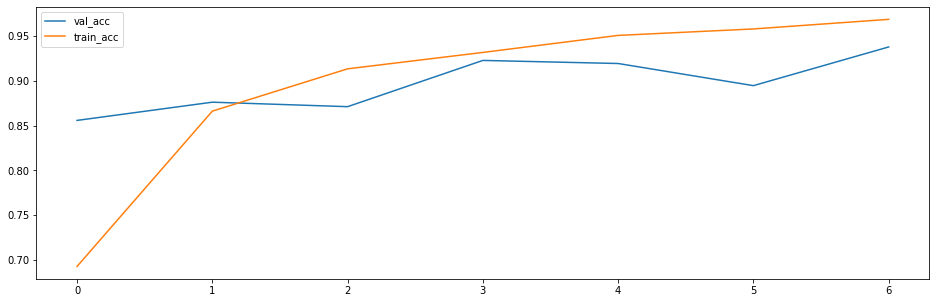

In [63]:
plt.figure(figsize=(16,5))
plt.plot(history.history['val_acc'], label='val_acc')
plt.plot(history.history['acc'], label='train_acc')
plt.legend()

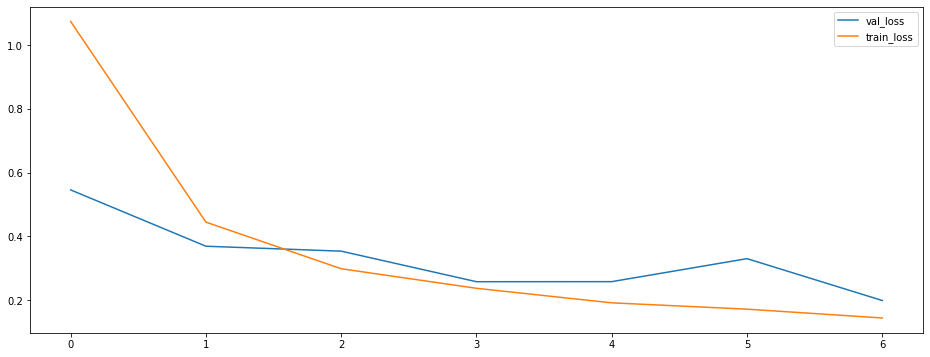

In [64]:
plt.figure(figsize=(16,6))
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['loss'], label='train_loss')
plt.legend()

[[2288  118]
 [  97 1500]]


<AxesSubplot:>

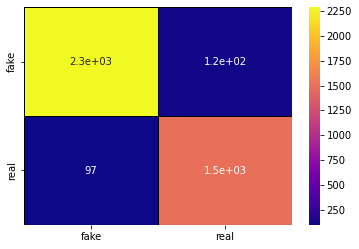

In [66]:
matrix = confusion_matrix(np.array(y_test.tolist()), test_pred.round())
print(matrix)

df_cm = pd.DataFrame(matrix,columns=['fake', 'real'], index=['fake', 'real'] )
sns.heatmap(df_cm, annot=True,cmap ='plasma', linecolor ='black', linewidths = 1)